In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install bitsandbytes
!pip install accelerator
!pip install -Uqqq
!pip -qqq install bitsandbytes accelerate
!pip install accelerate
!pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached accelerator-2024.3.8.dev1.tar.gz (379 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      Accelerator only works on posix platforms (like Linux).
      You could try running under WSL.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: You must give at least one requirement to install (see "pip help install")


  Cloning https://github.com/huggingface/accelerate to c:\users\20301065\appdata\local\temp\pip-req-build-aeepfu7o
  Resolved https://github.com/huggingface/accelerate to commit 6d92198ef4d162a4e9e4ffc350586174bd771e7f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for accelerate: filename=accelerate-0.30.0.dev0-py3-none-any.whl size=299481 sha256=87d5f71f1b1f175fe8769c34c76b12f35015b8f9d3287cd4193e6235ed33c1aa
  Stored in directory: C:\Users\20301065\AppData\Local\Temp\pip-ephem-wheel-cache-u1wzf69l\wheels\5a\6d\23\a920341d792c2e4a6f96daf5449e133329e4444224b0ea716b
Successfully built acc

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate 'C:\Users\20301065\AppData\Local\Temp\pip-req-build-aeepfu7o'


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import matplotlib.pyplot as plt
import numpy as np


c:\Users\20301065\AppData\Local\anaconda3\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "mistralai/Mistral-7B-v0.1"
print(torch.cuda.is_available())

True


In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
!pip show accelerate

Name: accelerate
Version: 0.30.0.dev0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: c:\Users\20301065\AppData\Local\anaconda3\envs\env\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [6]:
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


In [39]:
def get_attention_heatmap(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device) 

    with torch.no_grad():
        # Get attention weights
        outputs = model(**inputs, output_attentions=True)
        attention_heatmap = torch.stack(outputs.attentions)

    return attention_heatmap

def calculate_layer_statistics(attention_heatmaps):
    # Flatten the attention heatmap for each layer across all attention heads and tokens
    flattened_attentions = attention_heatmaps.view(attention_heatmaps.size(0), attention_heatmaps.size(1), -1)

    layer_means = flattened_attentions.mean(dim=2)
    layer_medians = flattened_attentions.median(dim=2).values
    layer_stds = flattened_attentions.std(dim=2)
    
    return layer_means, layer_medians, layer_stds

def plot_comparison_graph(prompt1_values, prompt2_values, title, ylabel):
    layers = range(1, len(prompt1_values) + 1)
    
    prompt1_values = prompt1_values.cpu().numpy()
    prompt2_values = prompt2_values.cpu().numpy()

    plt.figure(figsize=(15, 6))  

    plt.plot(layers, prompt1_values, color='red', marker='o', linestyle='dotted', label='Before')
    plt.plot(layers, prompt2_values, color='green', marker='o', linestyle='dotted', label='Afer')

    plt.title(title)
    plt.xlabel('Layers')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    
    plt.xticks(layers)

    plt.show()


# ATTENTION HEATMAP COMPARISON FOR TWO SMALL PROMPTS
Here, the Red curve refers to the plots before hallucination reduction, and green refers to after

In [30]:
prompt1 = "Hello World?"
prompt2 = "Goodbye World"
attentions1, attentions2 = get_attention_heatmap(prompt1), get_attention_heatmap(prompt2)
mean_attentions1, median_attentions1, std_attentions1 = calculate_layer_statistics(attentions1)
mean_attentions2, median_attentions2, std_attentions2 = calculate_layer_statistics(attentions2)

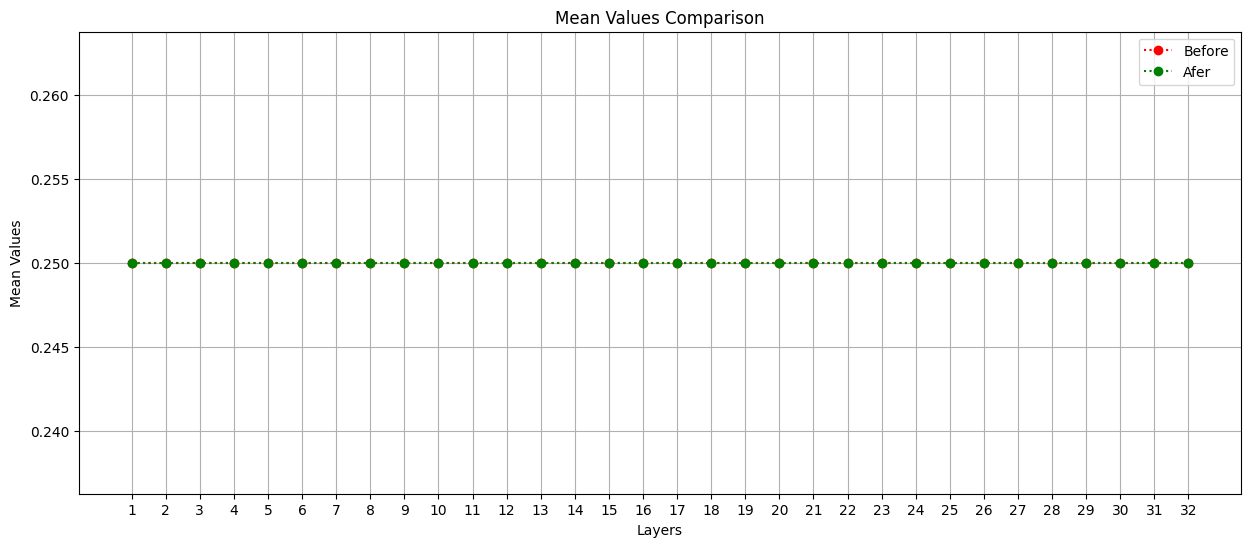

In [31]:
plot_comparison_graph(mean_attentions1, mean_attentions2, 'Mean Values Comparison', 'Mean Values')

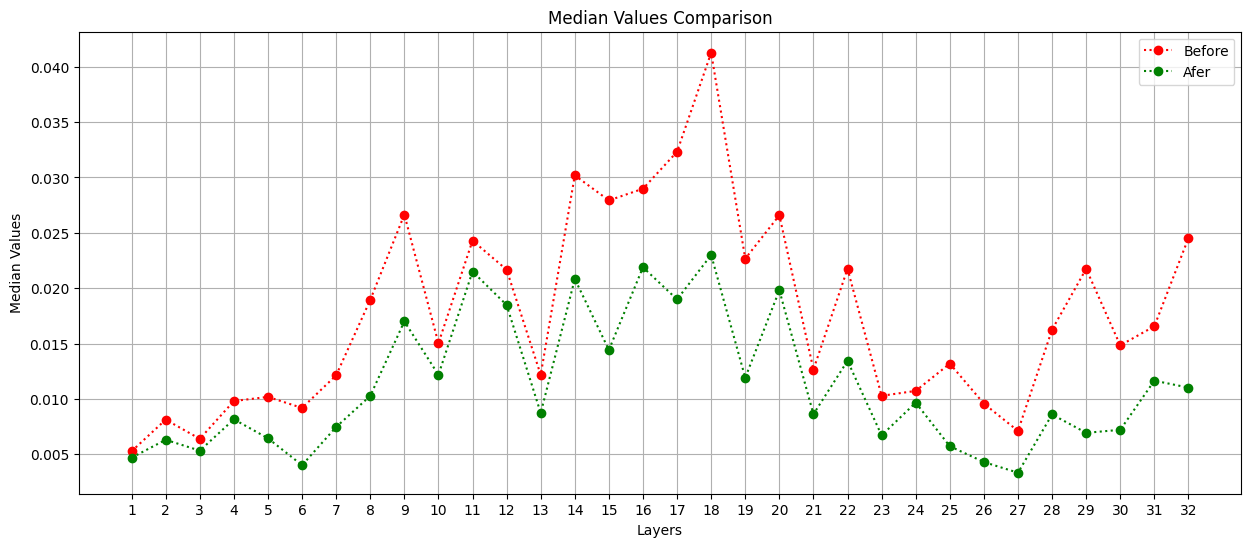

In [32]:
plot_comparison_graph(median_attentions1, median_attentions2, 'Median Values Comparison', 'Median Values')

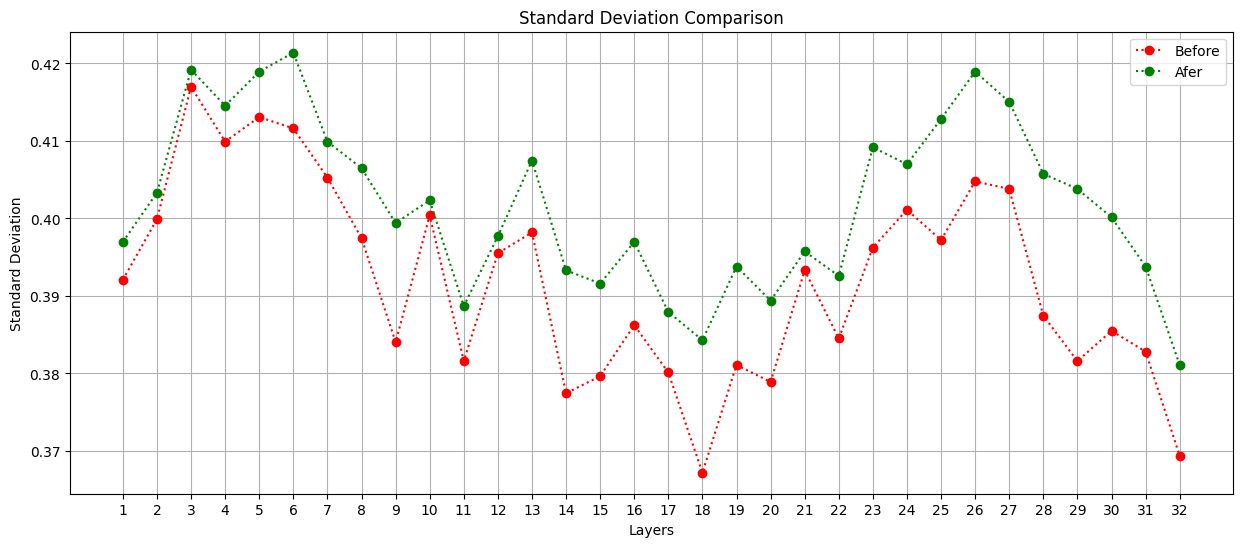

In [33]:
plot_comparison_graph(std_attentions1, std_attentions2, 'Standard Deviation Comparison', 'Standard Deviation')

## ATTENTION HEATMAP COMPARISON FOR LARGE INPUTS
When the input gets too large, the mean, median and the standered deviation curve gets more flatter

In [34]:
prompt1 = "Anwwer the question in a numbered list of 25-30 items. In the numbered list, just write the individual names. Don't add anything else.\n\nActual Question: Who are some actors who were born in RJ, Rio de Janeiro?\n"
prompt2 = "Given the following  original question and the baseline response, there are a couple of verification question-answer pairs. Based on those pairs revise the baseline response to the original question. Make sure to answer in a numbered list. Just write the names. Don't add anytthing extra\nActual Original Question: Who are some actors who were born in RJ, Rio de Janeiro?\nBaseline Answer: 1. Leonardo DiCaprio\n2. Penelope Cruz\n3. Wagner Moura\n4. Fernanda Torres\n5. Rodrigo Santoro\n6. Sonia Braga\n7. Claudio Cardinale\n8. Maria Grazia Chiuri\n9. Ana Paula Aragon\n10. Cristina Ferreira\n11. Marcelo Rubens Paiva\n12. Adriana Barraza\n13. Carlos Moreno Dalla\n14. Luiz Fernando de Assis\n15. Mariana Cardeal\n16. Nuno Lopes\n17. Pedro Borges\n18. Renato Gracie\n19. Ricardo Abreu\n20. Rodrigo Santos\n21. Sandro Mendon\u00e7a\n22. Sergio Ag\u00fcero\n23. Silvio Berlusconi\n24. Tiago Sagredo\n25. Vitor Hugo\n\nVerification Questions & Answer Pairs From another source:\nQ1: Can you confirm if Leonardo DiCaprio was actually born in Rio de Janeiro\nA1: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ2: Was Penelope Cruz born in Rio de Janeiro as well\nA2: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ3: Do you have any information about Wagner Moura's birthplace\nA3: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ4: Is it true that Fernanda Torres was born in Rio de Janeiro\nA4: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ5: Can you provide details about Rodrigo Santoro's place of birth\nA5: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ6: Did Sonia Braga grow up in Rio de Janeiro\nA6: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ7: Was Claudio Cardinale born in Rio de Janeiro\nA7: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ8: Is Maria Grazia Chiuri originally from Rio de Janeiro\nA8: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ9: Can you confirm if Ana Paula Aragon was born in Rio de Janeiro\nA9: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ10: Was Cristina Ferreira born in Rio de Janeiro\nA10: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ11: Do you know where Marcelo Rubens Paiva was born\nA11: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ12: Was Adriana Barraza born in Rio de Janeiro\nA12: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ13: Can you provide information about Carlos Moreno Dalla's birthplace\nA13: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ14: Is Luiz Fernando de Assis originally from Rio de Janeiro\nA14: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ15: Do you have any details about Mariana Cardeal's birthplace\nA15: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ16: Was Nuno Lopes born in Rio de Janeiro\nA16: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ17: Can you confirm if Pedro Borges was born in Rio de Janeiro\nA17: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ18: Is Renato Gracie originally from Rio de Janeiro\nA18: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ19: Do you know where Ricardo Abreu was born\nA19: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ20: Was Rodrigo Santos born in Rio de Janeiro\nA20: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ21: Can you provide information about Sandro Mendon\u00e7a's birthplace\nA21: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ22: Is Sergio Ag\u00fcero originally from Rio de Janeiro\nA22: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ23: Do you have any details about Silvio Berlusconi's birthplace\nA23: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\nQ24: Is Tiago Sagredo originally from Rio de Janeiro\nA24: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Fernanda Montiel\n* Rodrigo Santoro\n* Cl\u00e1udio Ramos\n* Marcelo Mazzarella\n* Cristina Ferreira\n\nQ25: Can you confirm if Vitor Hugo was born in Rio de Janeiro\nA25: Some actors who were born in RJ, Rio de Janeiro include:\n\n* Leonardo DiCaprio (born November 1974)\n* Pen\u00e9lope Cruz (born January 1980)\n* Rodrigo Santoro (born July 20, 1975)\n* Fernanda Torres (born February 13, 1969)\n* Sonia Braga (born March 12, 1985)\n\n\nNote: You should generate a numbered list, where in each line, there should be exactly one name.\n"

In [35]:
attentions1, attentions2 = get_attention_heatmap(prompt1), get_attention_heatmap(prompt2)
mean_attentions1, median_attentions1, std_attentions1 = calculate_layer_statistics(attentions1)
mean_attentions2, median_attentions2, std_attentions2 = calculate_layer_statistics(attentions2)

In [20]:
print(mean_attentions1.shape)
print(mean_attentions2.shape)
print(median_attentions1.shape)
print(median_attentions2.shape)
print(std_attentions1.shape)
print(std_attentions2.shape)


torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


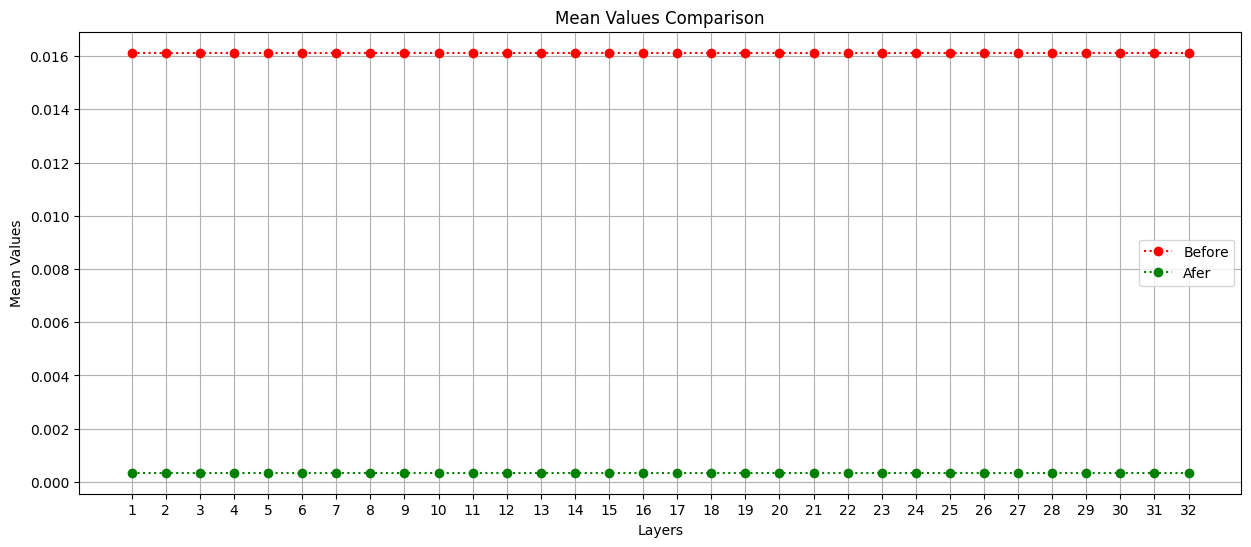

In [36]:
plot_comparison_graph(mean_attentions1, mean_attentions2, 'Mean Values Comparison', 'Mean Values')

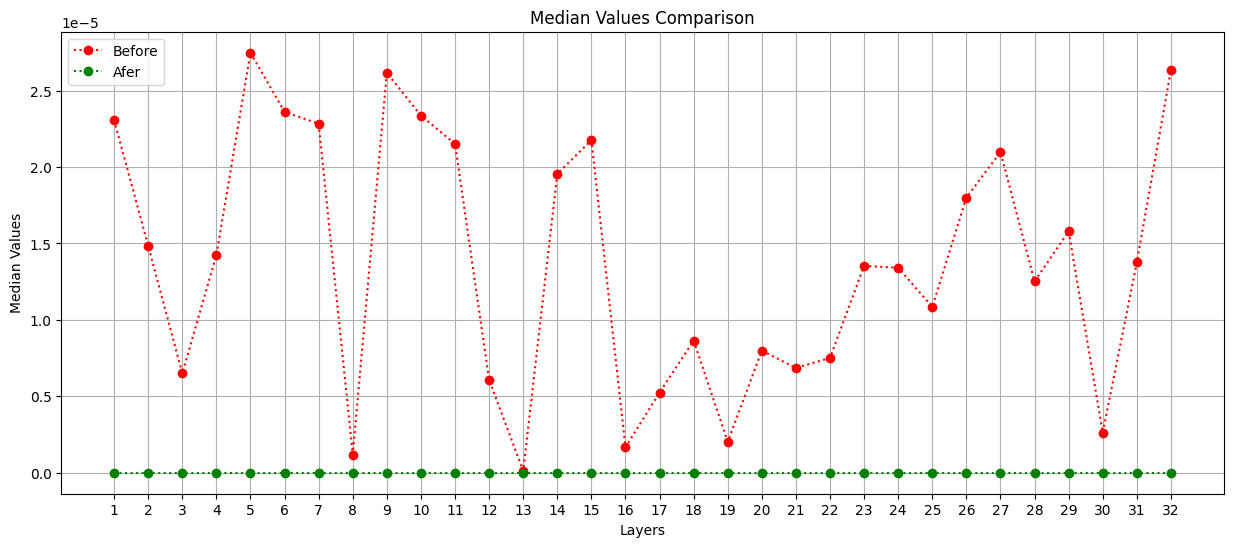

In [37]:
plot_comparison_graph(median_attentions1, median_attentions2, 'Median Values Comparison', 'Median Values')

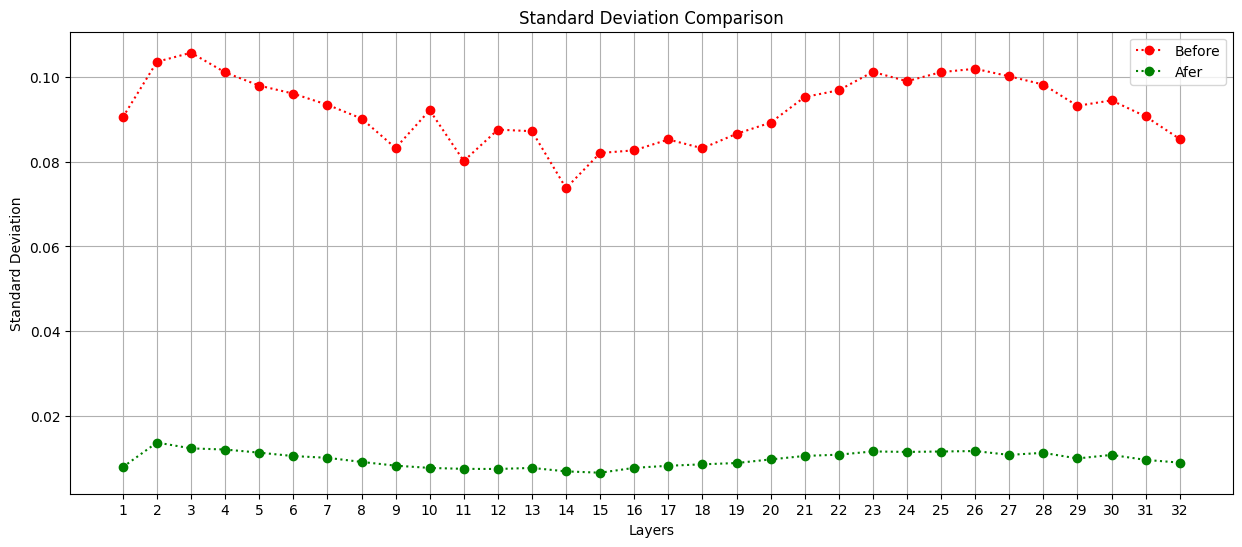

In [38]:
plot_comparison_graph(std_attentions1, std_attentions2, 'Standard Deviation Comparison', 'Standard Deviation')
